# 4.1 Further classification of wheel movement states
- ballistic (True or False)
- choice (none, L, R)
- inflections (none, 1, more)

In [1]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
import brainbox.behavior.wheel as wh
from scipy.signal import savgol_filter
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, best__kappa, best_lag_kappa, state_identifiability
from plotting_functions import plot_x_y_dynamics, plot_avg_state, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, plot_states_aligned, traces_over_few_sates
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from wheel_functions import wheel_trial_epoch
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from one_functions_generic import prepro
from design_functions import wheel_velocity
# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')


# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from plotting_functions import traces_over_few_sates


## Parameters

In [2]:
bin_size = 0.1
multiplier = 1/bin_size

response_threshold = 0.3 # radians
velocity_threshold = 100 # degrees/s
monotonic_threshold = -.0005  # TODO: should validate more methodically

## Get data

In [3]:
# Load preprocessed data
results_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//4_analyses/'
os.chdir(results_path)
states_trial_type = pickle.load(open("states_trial_type_14oct2024.pkl", "rb"))
# states_trial_type = pickle.load(open("states_trial_type_10oct2024.pkl", "rb"))

# Get extended states with wheel data

In [5]:

eids = np.unique(states_trial_type['session'])

mouse_movements_df = pd.DataFrame(columns=['session', 'movement_id', 'time', 'norm_time', 'wheel_pos', 
                                            'wheel_vel', 'wheel_pos_resp', 'wheel_vel_resp',  'ballistic', 'response'])

for e, eid in enumerate(eids[:1]):
    eid = '934dd7a4-fbdc-459c-8830-04fe9033bc28'
    eid = '03063955-2523-47bd-ae57-f7489dd40f15'

    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]

    # Get time of last unbiased trial
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)

    # Calculate wheel velocity
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, unbiased)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    df = states_trial_type.loc[(states_trial_type['session']==eid)].sort_values(by='Bin')

    check_states = np.array(df['identifiable_states'])
    on = [s[0] == '1' for s in check_states]
    df['wheel_on'] = np.zeros(len(df))
    df['wheel_on'][on] = 1

    df['dif'] = np.zeros(len(df)) * np.nan
    df['dif'][1:] = np.diff(df['wheel_on'])

    movement_onsets = np.array(df.loc[df['dif']==1., 'Bin'])
    movement_offsets = np.array(df.loc[df['dif']==-1., 'Bin'])

    # Calculate per movement

    for m, onset in enumerate(movement_onsets[:-1]):
        #try:

        movement_df = pd.DataFrame(columns=['session', 'movement_id', 'time', 'norm_time', 'wheel_pos', 
                                            'wheel_vel', 'wheel_pos_resp', 'wheel_vel_resp', 
                                            'ballistic', 'response'])
        
        if movement_offsets[m] < onset:
            offset = movement_offsets[m+1]
        else:
            offset = movement_offsets[m]
            
        movement_pos = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                    & (wheel_vel['Bin']<offset), 'Wheel position']
        movement_times = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                    & (wheel_vel['Bin']<offset), 'Wheel times']
        
        time_interval = (offset - onset) * .1 # convert from Bins to seconds
        movement_pos_deg = movement_pos * 180 / np.pi # convert from radians to degrees
        movement_velocity = np.diff(movement_pos_deg) /  np.diff(movement_times)
        norm_movement_pos = np.array(movement_pos) - np.array(movement_pos)[0]

        # Save data
        movement_df['time'] = movement_times
        movement_df['norm_time'] = movement_times - np.array(movement_times)[0]
        movement_df['wheel_pos'][1:] = norm_movement_pos[1:]
        movement_df['wheel_vel'][1:] = movement_velocity
        movement_df['movement_id'] = m
        movement_df['session'] = eid

        # Find positions above threshold
        pos_above_thr = np.where(np.abs(norm_movement_pos)>.3)
        if len(pos_above_thr[0]) > 0:
            response_index = np.where(np.abs(norm_movement_pos)>.3)[0][0]
            movement_df['response'] = np.sign(norm_movement_pos[response_index])

            # Find ballistic movements
            # Velocity above threshold
            vel_above_thr = np.where(np.abs(movement_velocity)>=100)
            # Response duration
            response_duration = np.array(movement_times)[response_index] - np.array(movement_times)[0]
            # Monotonic change?
            response_movement = norm_movement_pos[:response_index]
            smoothed_movement = savgol_filter(response_movement, 100, 2)
            significant_inflection = np.where(np.diff(np.abs(smoothed_movement))<monotonic_threshold)

            movement_df['wheel_pos_resp'][:response_index] = norm_movement_pos[:response_index]
            movement_df['wheel_vel_resp'][:response_index] = movement_velocity[:response_index]

            if len(vel_above_thr[0]) > 0:
                # Check if threshold achieved before 1 s and 
                # velocity threshold achieved before response threshold and
                # monotonically changing before response threshold
                if (np.sum(vel_above_thr[0] < response_index) > 0) & (response_duration < 1) & (len(significant_inflection[0]) == 0):
                    movement_df['ballistic'] = True
                else:
                    movement_df['ballistic'] = False
            else:
                movement_df['ballistic'] = False
        else:
            movement_df['response'] = np.nan
            movement_df['ballistic'] = False
            
        # Save to big df
        if len(mouse_movements_df) == 0:
            mouse_movements_df = movement_df.copy()
        else:
            mouse_movements_df = mouse_movements_df.append(movement_df)
        # except:
        #     print('Movement not available?')

/tmp/ipykernel_60936/1038661393.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/tmp/ipykernel_60936/1038661393.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])
/tmp/ipykernel_60936/1038661393.py:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movement_df['wheel_pos'][1:] = norm_movement_pos[1:]
/tmp/ipykernel_60936/1038661393.py:67: SettingWithCopyWarning: 
A va

# Find example trials for each cluster

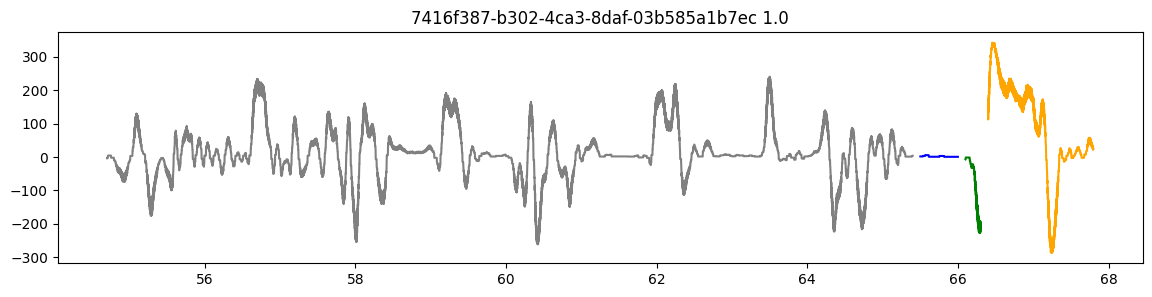

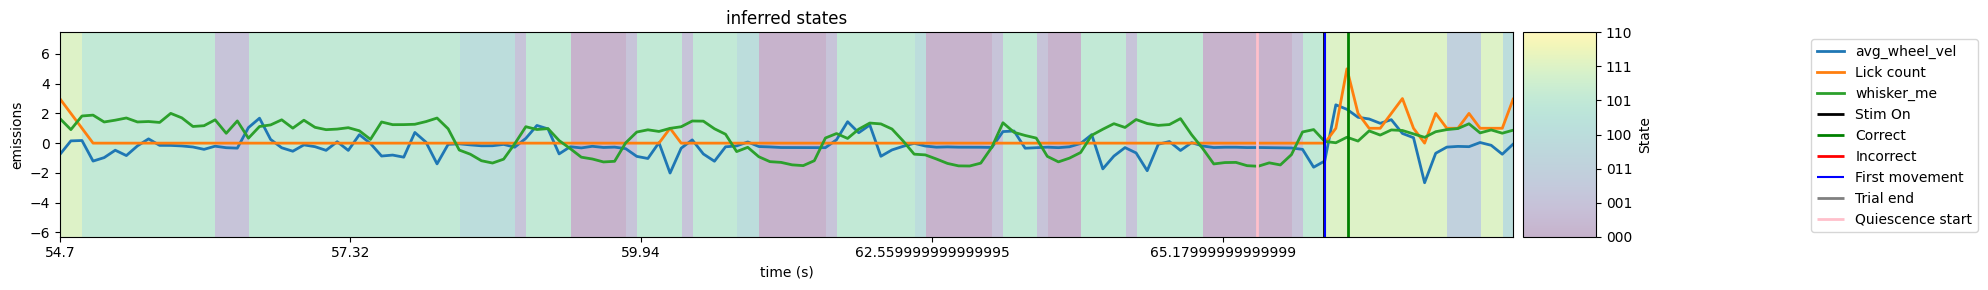

In [15]:
sessions = states_trial_type['session']
states_trial_type['trial_str'] = states_trial_type['trial_id'].astype(str)
states_trial_type['sample'] = states_trial_type[['session', 'trial_str']].agg(' '.join, axis=1)

for e, eid in enumerate(sessions[:1]):

    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)

    session_df = states_trial_type.loc[states_trial_type['session']==eid]
    
    samples = session_df['sample'].unique()
    
    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    
    
    for s, sample in enumerate(samples[:1]):

        trial = states_trial_type.loc[states_trial_type['sample']==sample]
        pre_qui = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label']=='Pre-quiescence')]
        qui = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label']=='Quiescence')]
        choice = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label'].isin(['Choice', 'Stimulus']))]
        iti = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label']=='ITI')]

        pre_qui_init = np.min(pre_qui['Bin']) * 0.1
        pre_qui_end = (np.max(pre_qui['Bin']))* 0.1
        qui_init = np.min(qui['Bin'])* 0.1
        qui_end = (np.max(qui['Bin']))* 0.1
        choice_init = np.min(choice['Bin'])* 0.1
        choice_end = (np.max(choice['Bin']))* 0.1
        iti_init = np.min(iti['Bin'])* 0.1
        iti_end = (np.max(iti['Bin']))* 0.1

        movement_pos_deg = pos * 180 / np.pi # convert from radians to degrees
                
                
        fig, ax = plt.subplots(figsize=(14, 3))
        # Plot pre-quiescence
        time_interval = (pre_qui_end - pre_qui_init) * .1 # convert from Bins to seconds
        movement_snippet = movement_pos_deg[np.where((wheel_times> pre_qui_init) & (wheel_times< pre_qui_end))]
        time_snippet = wheel_times[np.where((wheel_times> pre_qui_init) & (wheel_times< pre_qui_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        plt.plot(time_snippet[1:], movement_velocity, color='grey')

        # Plot quiescence
        time_interval = (qui_end - qui_init) * .1 # convert from Bins to seconds
        movement_snippet = movement_pos_deg[np.where((wheel_times> qui_init) & (wheel_times< qui_end))]
        time_snippet = wheel_times[np.where((wheel_times> qui_init) & (wheel_times< qui_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        plt.plot(time_snippet[1:], movement_velocity, color='blue')

        # Plot choice
        time_interval = (choice_end - choice_init) * .1 # convert from Bins to seconds
        movement_snippet = movement_pos_deg[np.where((wheel_times> choice_init) & (wheel_times< choice_end))]
        time_snippet = wheel_times[np.where((wheel_times> choice_init) & (wheel_times< choice_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        if list(trial['correct'])[0]==1.0:
            color='green'
        else:
            color='red'
        plt.plot(time_snippet[1:], movement_velocity, color=color)

        # Plot iti
        time_interval = (iti_end - iti_init) * .1 # convert from Bins to seconds
        movement_snippet = movement_pos_deg[np.where((wheel_times> iti_init) & (wheel_times< iti_end))]
        time_snippet = wheel_times[np.where((wheel_times> iti_init) & (wheel_times< iti_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        plt.plot(time_snippet[1:], movement_velocity, color='orange')
        plt.title(sample)
        
        try:
            """ Plot raw traces over states """
            init = pre_qui_init * multiplier # First bin
            inter = iti_end * multiplier - init
            var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']
            mapping = {unique: key for unique, key in zip(states_trial_type.most_likely_states.unique(), states_trial_type.identifiable_states.unique())}
            traces_over_few_sates(init, inter, states_trial_type, session_trials, var_names, multiplier, mapping)
        except:
            print('something wrong')
        

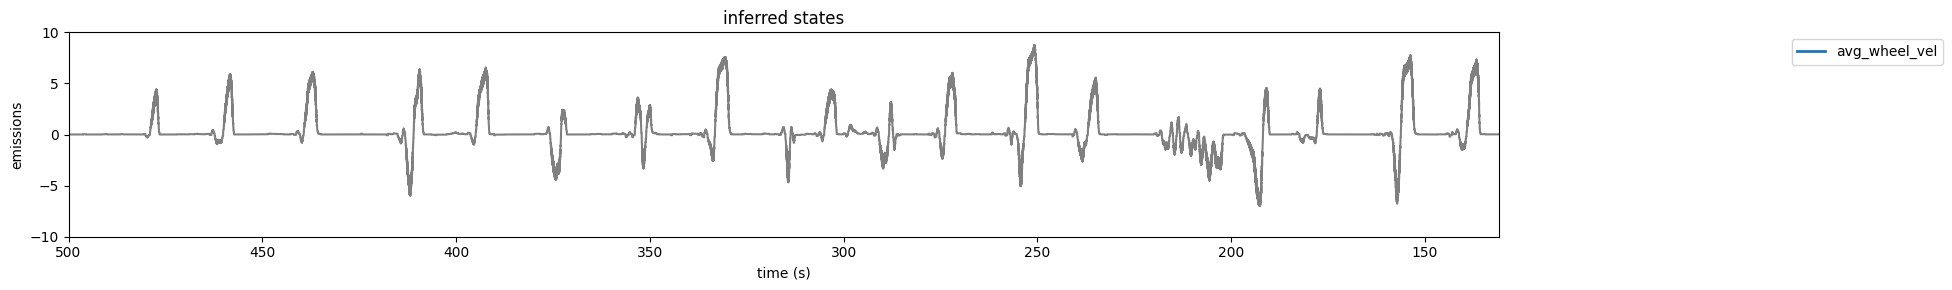

In [10]:
    # def traces_over_few_sates (init, inter, design_matrix, session_trials, columns_to_standardize, multiplier, inverted_mapping):
    # Compute the most likely states
    design_matrix = trial.copy()
    columns_to_standardize = var_names.copy()
    columns_to_standardize = 'avg_wheel_vel'
    inverted_mapping = mapping.copy()
    init = 500
    end = init + inter

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 3))

    df_normalized = design_matrix
    df_normalized['Bin'] = design_matrix['Bin']

    # use_normalized = df_normalized.loc[(df_normalized['Bin']>init) & (df_normalized['Bin']<end)]
    

    movement_snippet = movement_pos_deg
    time_snippet = wheel_times
    movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
    
    axs.plot(wheel_times[1:]*10, movement_velocity/40, color='grey')
    axs.plot(np.array(df_normalized['Bin']), np.array(df_normalized[columns_to_standardize]), label=columns_to_standardize, linewidth=2)


    # axs.set_ylim(plot_min, plot_max)
    axs.set_ylim(-10, 10)
    axs.set_ylabel("emissions")
    axs.set_xlabel("time (s)")
    axs.set_xlim(init, end-init)
    # axs.set_xticks(np.arange(0, inter, inter/5),np.arange(init/multiplier, 
    #                                                       end/multiplier, (inter/multiplier)/5))
    axs.set_title("inferred states")
    axs.legend(loc='upper left', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()

# Need to fix plotting function to align states with trial events: work from here and then update on 'plotting_functions.py'

NameError: name 'design_matrix' is not defined

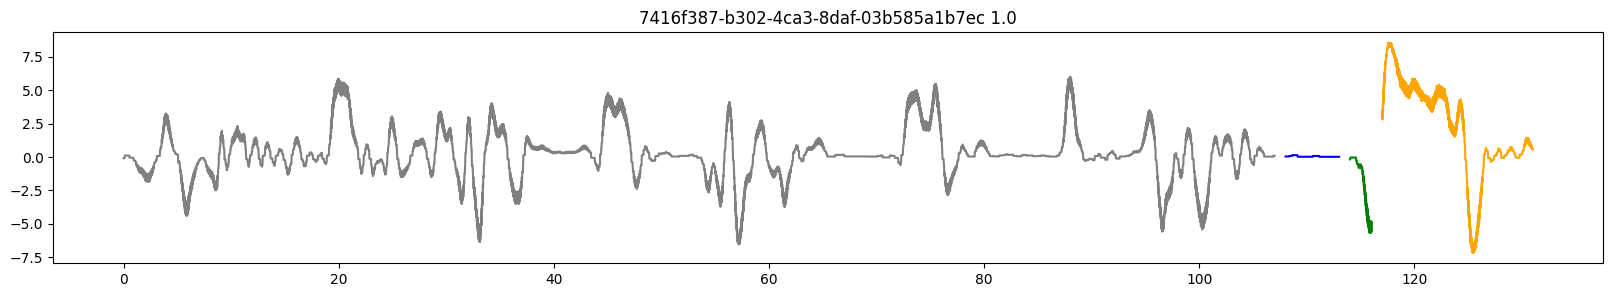

In [7]:

    fig, axs = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(20, 3))

    # Plot pre-quiescence
    movement_snippet = movement_pos_deg[np.where((wheel_times> pre_qui_init) & (wheel_times< pre_qui_end))]
    time_snippet = wheel_times[np.where((wheel_times> pre_qui_init) & (wheel_times< pre_qui_end))]
    movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
    plt.plot((time_snippet[1:]-pre_qui_init)*10, movement_velocity/40, color='grey')
    # Plot quiescence
    movement_snippet = movement_pos_deg[np.where((wheel_times> qui_init) & (wheel_times< qui_end))]
    time_snippet = wheel_times[np.where((wheel_times> qui_init) & (wheel_times< qui_end))]
    movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
    plt.plot((time_snippet[1:]-pre_qui_init)*10, movement_velocity/40, color='blue')
    # Plot choice
    movement_snippet = movement_pos_deg[np.where((wheel_times> choice_init) & (wheel_times< choice_end))]
    time_snippet = wheel_times[np.where((wheel_times> choice_init) & (wheel_times< choice_end))]
    movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
    if list(trial['correct'])[0]==1.0:
        color='green'
    else:
        color='red'
    plt.plot((time_snippet[1:]-pre_qui_init)*10, movement_velocity/40, color=color)
    # Plot iti
    movement_snippet = movement_pos_deg[np.where((wheel_times> iti_init) & (wheel_times< iti_end))]
    time_snippet = wheel_times[np.where((wheel_times> iti_init) & (wheel_times< iti_end))]
    movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
    plt.plot((time_snippet[1:]-pre_qui_init)*10, movement_velocity/40, color='orange')
    plt.title(sample)
    
    
    
    
    columns_to_standardize = var_names.copy()
    inverted_mapping = mapping.copy()
    end = init + inter

    df_normalized = states_trial_type.copy()
    df_normalized['Bin'] = design_matrix['Bin']
    use_normalized = df_normalized.loc[(df_normalized['Bin']>init) & (df_normalized['Bin']<end)]
    
    # To make sure color code is used correctly
    number_of_states = len(use_normalized['most_likely_states'].unique()) - np.sum(np.isnan(use_normalized['most_likely_states'].unique()))
    states_to_append = np.arange(0, number_of_states, 1)

    
    
    # Plot original values

    use_index0 = ~np.isnan(use_normalized[columns_to_standardize[0]])
    use_time0 = np.arange(0, len(use_index0), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
    use_index1 = ~np.isnan(use_normalized[columns_to_standardize[1]])
    use_time1 = np.arange(0, len(use_index1), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!
    use_index2 = ~np.isnan(use_normalized[columns_to_standardize[2]])
    use_time2 = np.arange(0, len(use_index2), 1)  # NOTE! If there are NaNs, x axis label will have the time wrong # NOTE!!

    axs.plot(use_time0, use_normalized[columns_to_standardize[0]], label=columns_to_standardize[0], linewidth=2)
    axs.plot(use_time1, use_normalized[columns_to_standardize[1]], label=columns_to_standardize[1], linewidth=2)
    axs.plot(use_time2, use_normalized[columns_to_standardize[2]], label=columns_to_standardize[2], linewidth=2)
    
    plot_max = 10
    plot_min = -10

    cax = axs.imshow(np.concatenate([use_normalized['most_likely_states'], states_to_append])[None,:], 
            extent=(0, len(np.concatenate([use_normalized['most_likely_states'], states_to_append])), plot_min, plot_max),
            aspect="auto",
            cmap='viridis',
            alpha=0.3) 

    divider = make_axes_locatable(axs)
    cax_colorbar = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(cax, cax=cax_colorbar, ax=axs)

    cbar.set_label('State')
    if len(inverted_mapping) > 0:
        # Set the ticks and labels based on the dictionary
        cbar.set_ticks(list(inverted_mapping.keys()))
        cbar.set_ticklabels(list(inverted_mapping.values()))
        
        
    axs.hlines(0, init, end, color='Black', linestyles='dashed', linewidth=2)
    axs.vlines(np.array(session_trials['goCueTrigger_times'] * 1*multiplier)-init, plot_min, plot_max, label='Stim On', 
               color='Black', linewidth=2)
    axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * 1*multiplier)-init, 
               plot_min, plot_max, label='Correct', color='Green', linewidth=2)
    axs.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * 1*multiplier)-init, 
               plot_min, plot_max, label='Incorrect', color='Red', linewidth=2)
    axs.vlines(np.array(session_trials['firstMovement_times'] * 1*multiplier)-init, plot_min, plot_max, label='First movement', color='Blue')
    axs.vlines(np.array(session_trials['intervals_0'] * 1*multiplier)-init, plot_min, plot_max, label='Trial end', color='Grey', linewidth=2)
    axs.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * 1*multiplier)-init, 
               plot_min, plot_max, label='Quiescence start', color='Pink', linewidth=2)

    axs.set_ylim(plot_min, plot_max)
    # axs.set_ylim(-10, 10)
    axs.set_ylabel("emissions")
    axs.set_xlabel("time (s)")
    axs.set_xlim(0, end-init)
    axs.set_xticks(np.arange(0, inter, inter/5),np.arange(init/multiplier, 
                                                          end/multiplier, (inter/multiplier)/5))
    axs.set_title("inferred states")
    axs.legend(loc='upper left', bbox_to_anchor=(1.2, 1))

    plt.tight_layout()
    plt.show()
    

In [29]:
session_df['sample']

KeyError: 'sample'

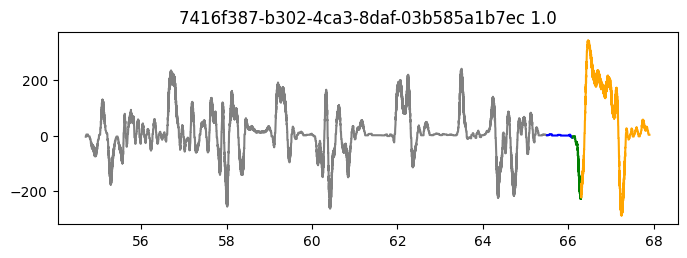

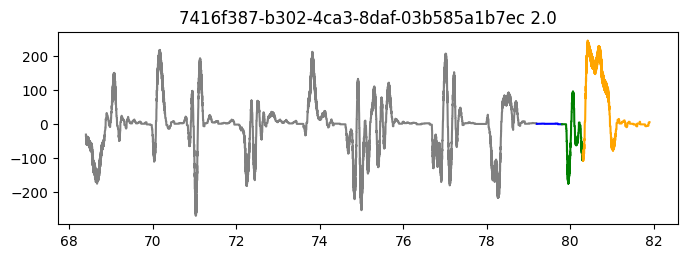

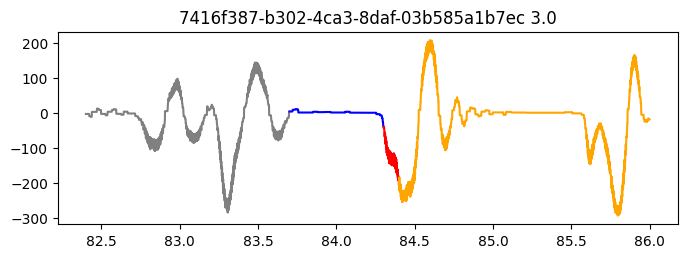

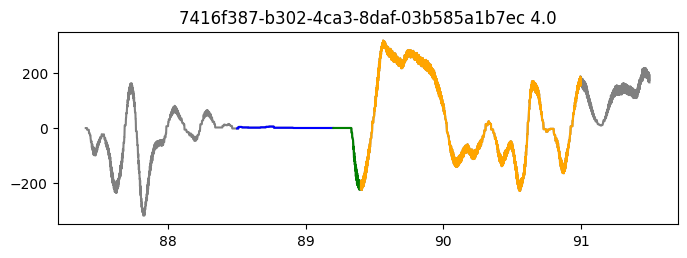

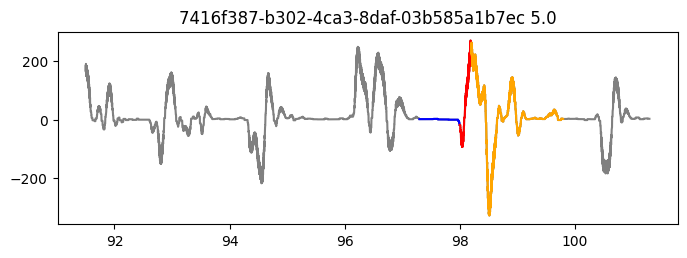

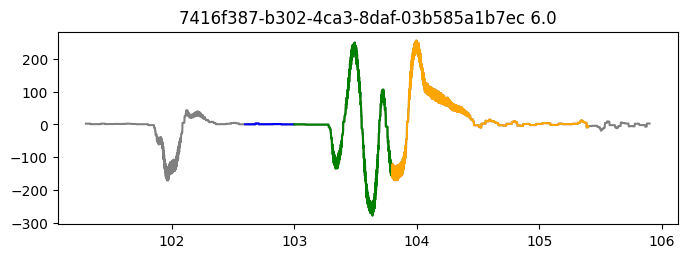

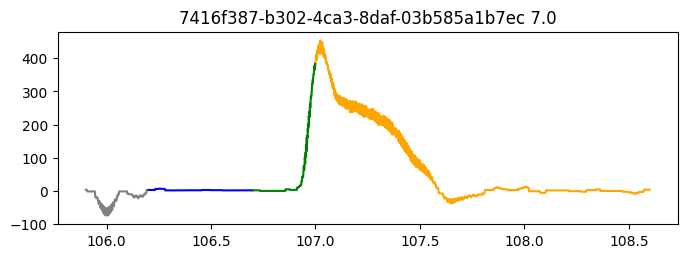

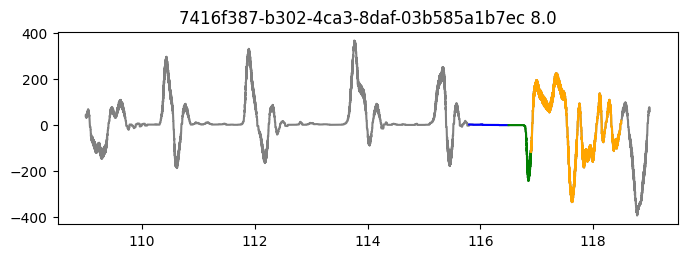

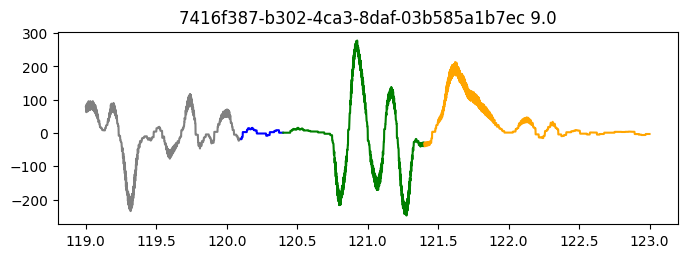

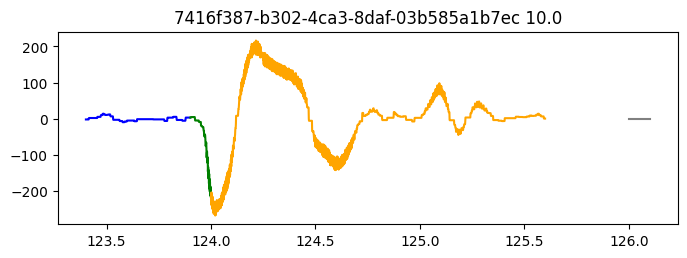

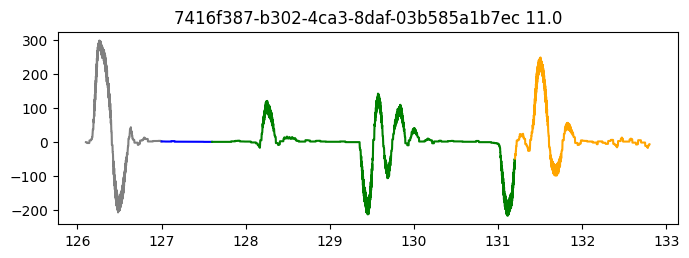

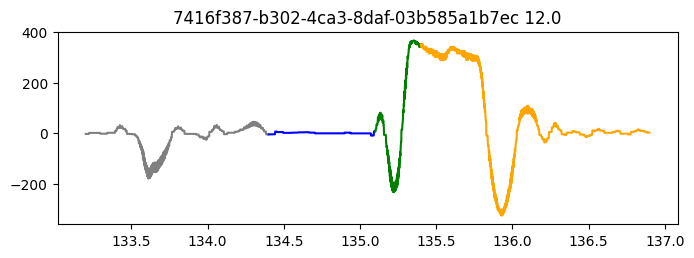

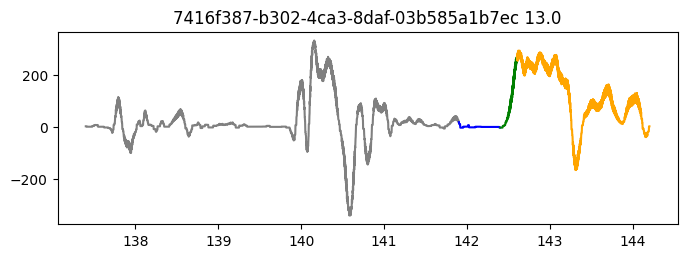

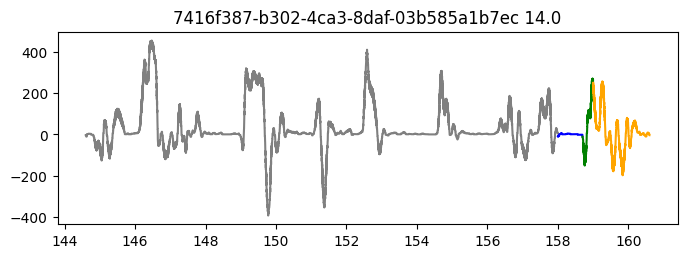

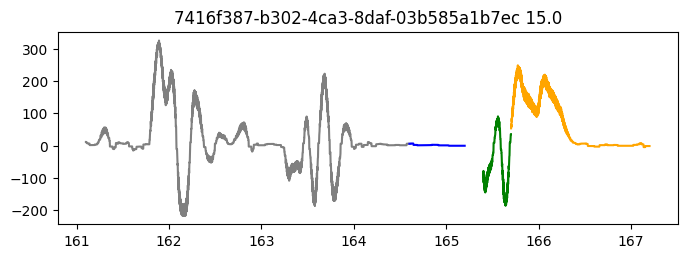

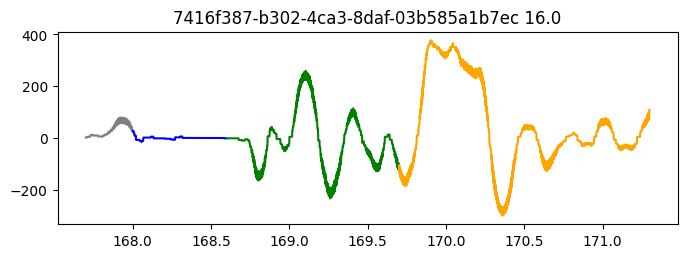

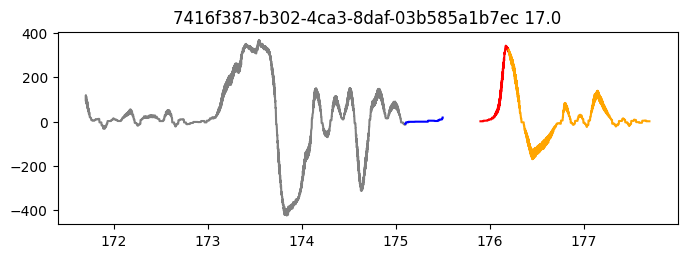

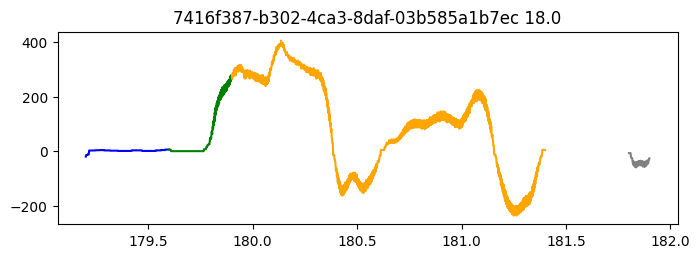

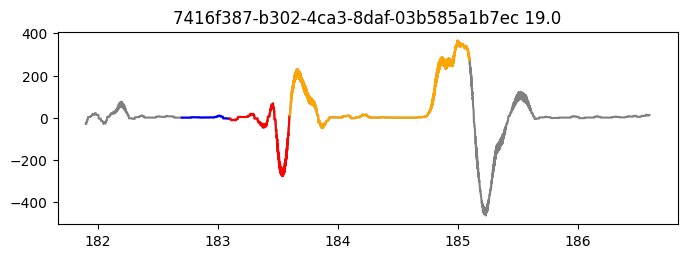

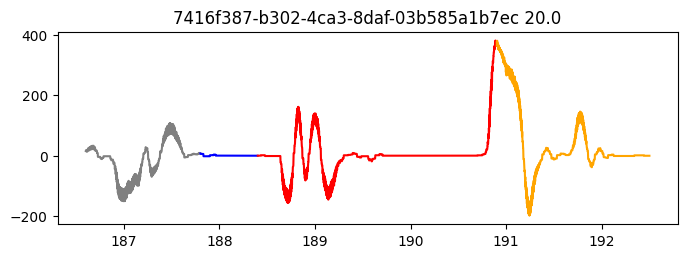

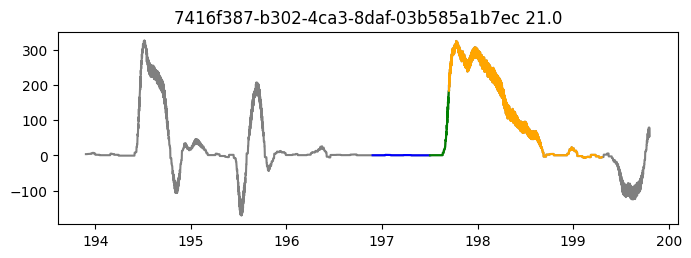

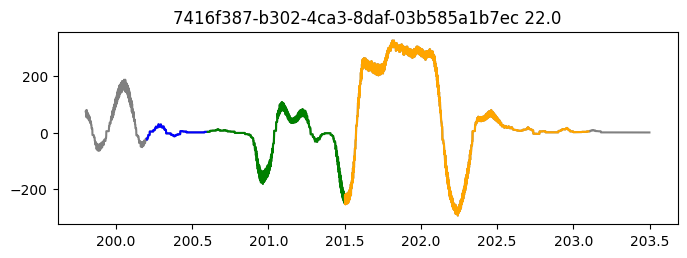

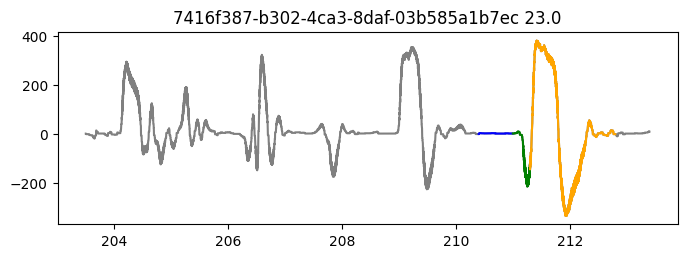

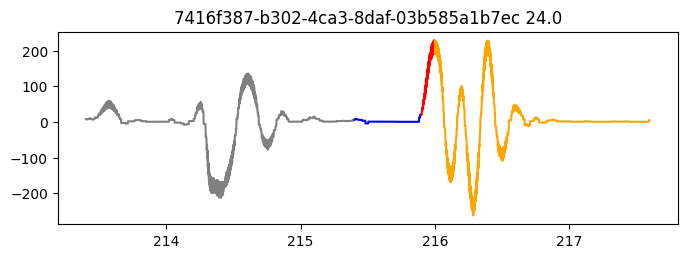

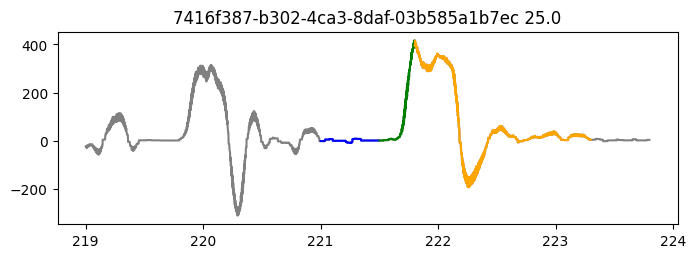

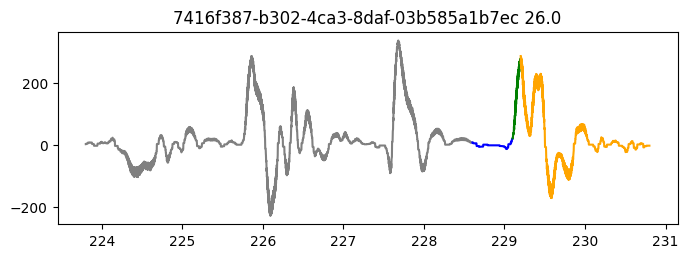

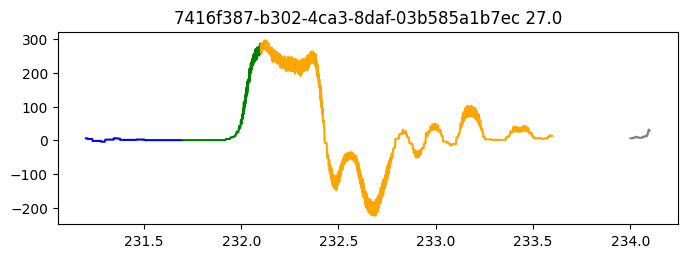

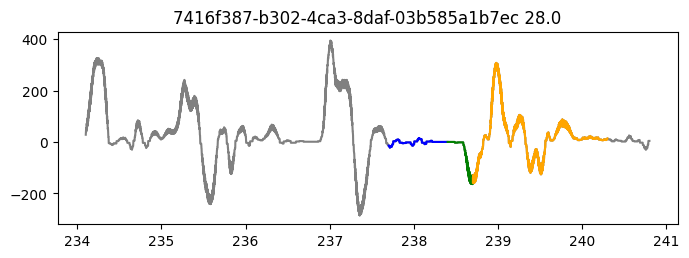

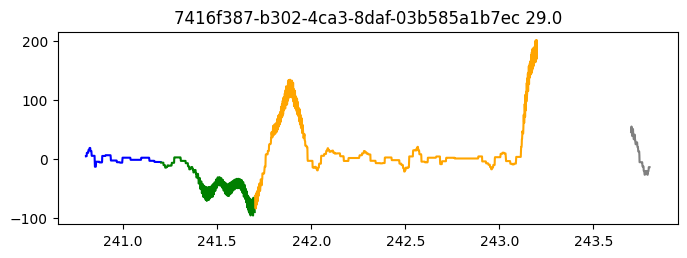

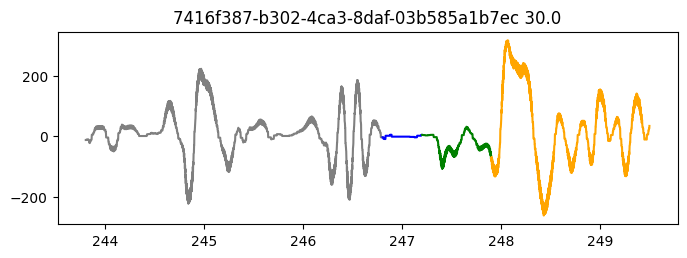

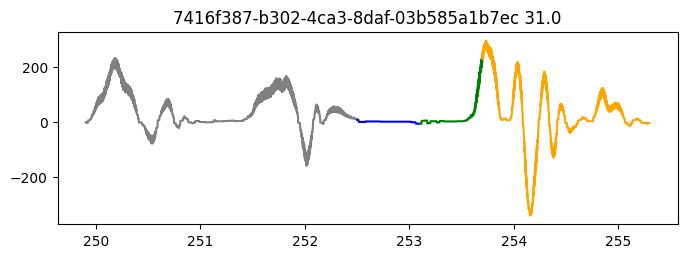

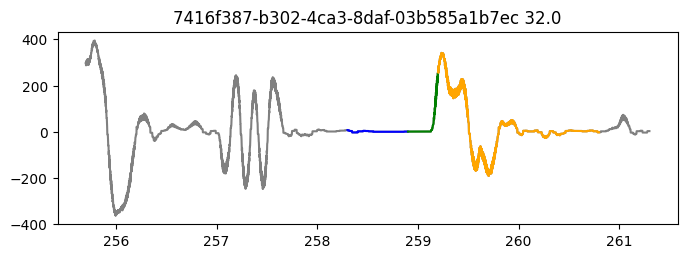

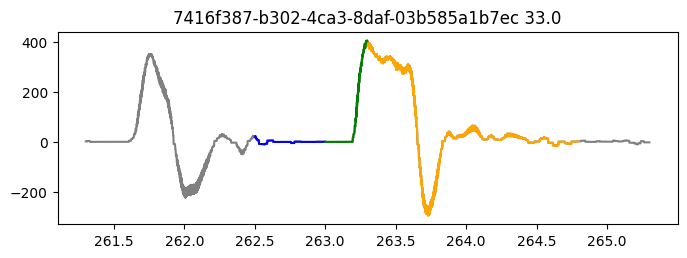

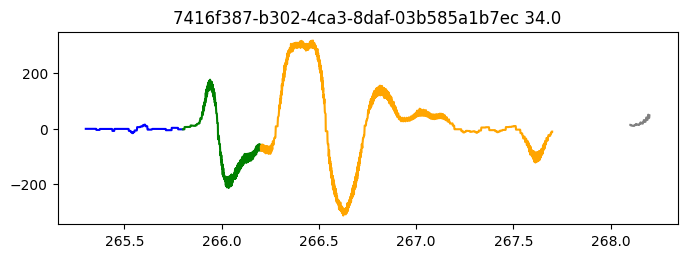

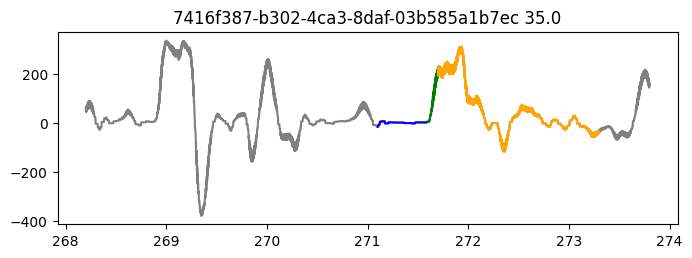

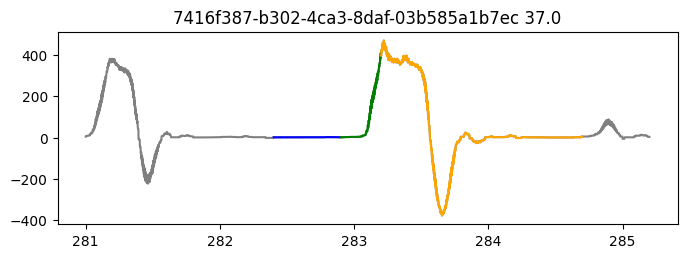

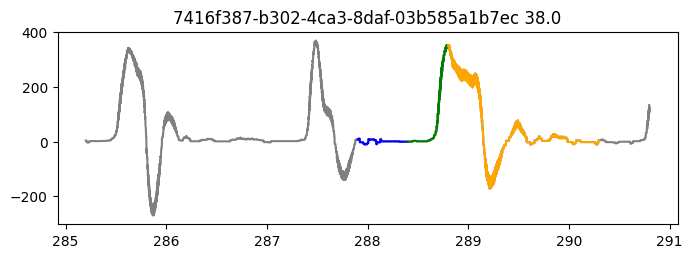

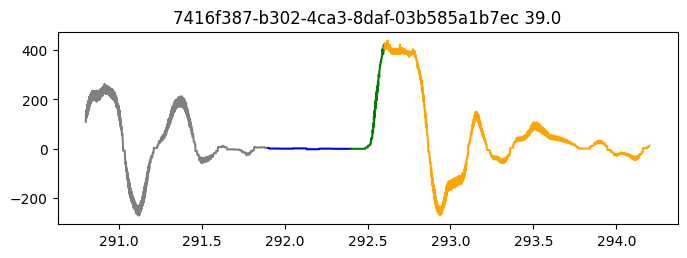

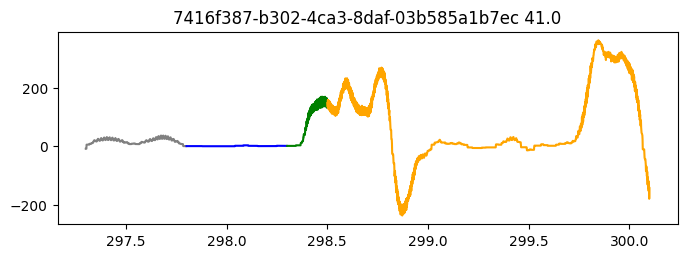

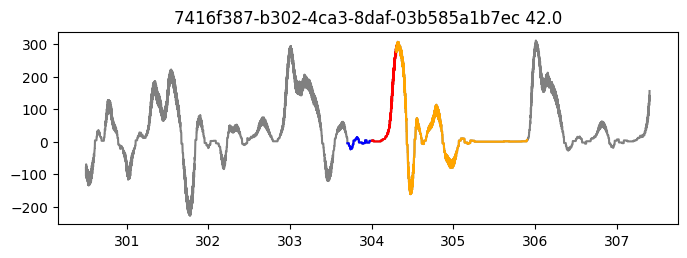

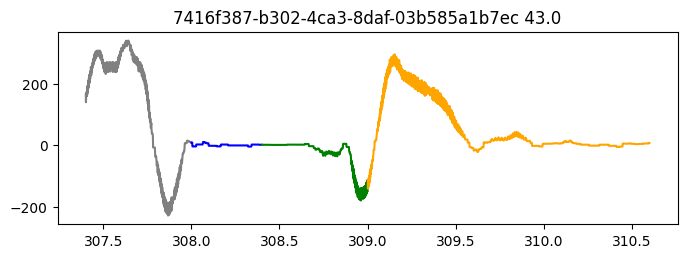

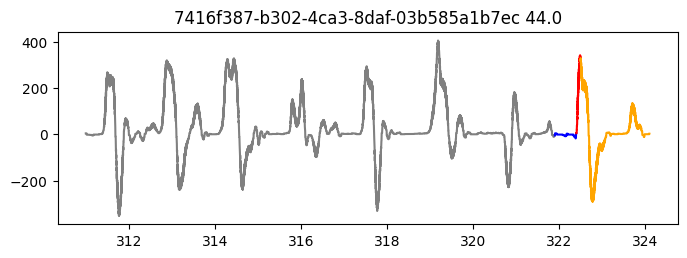

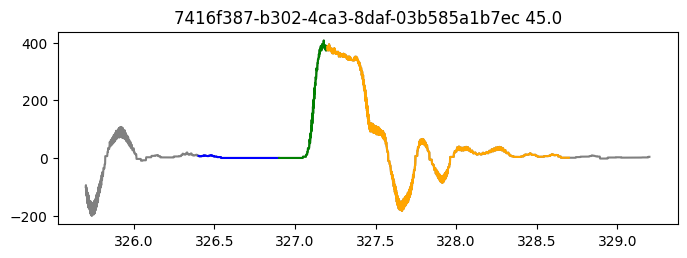

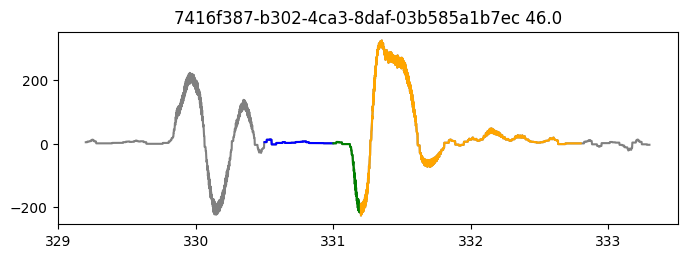

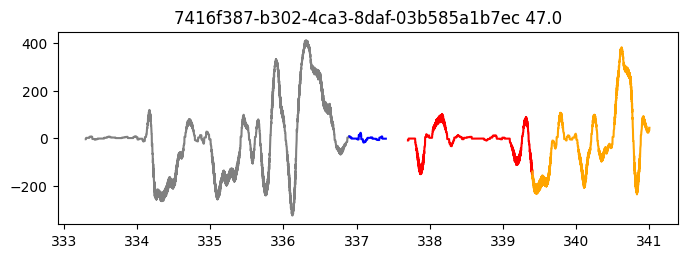

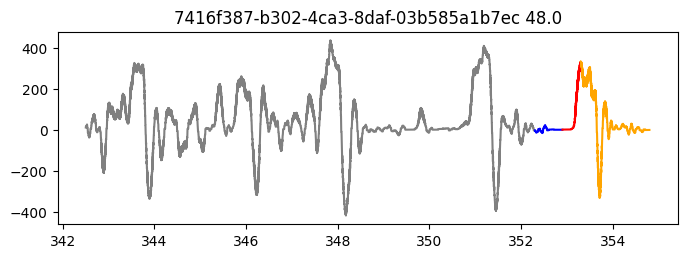

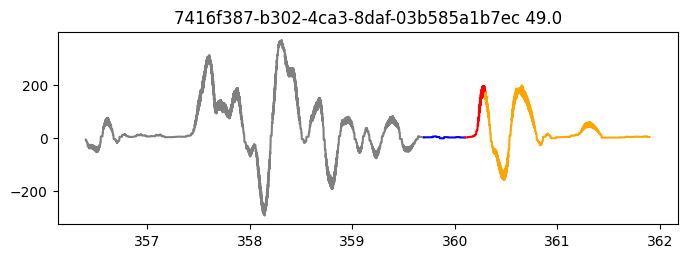

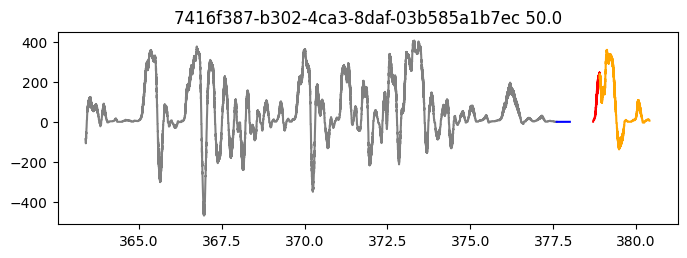

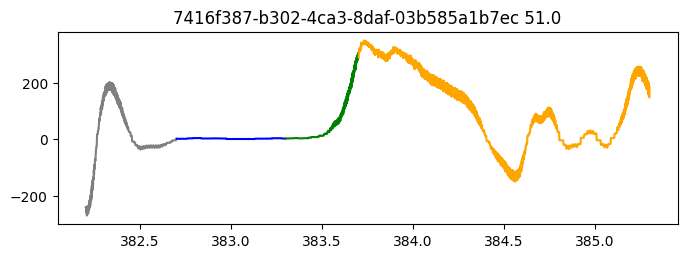

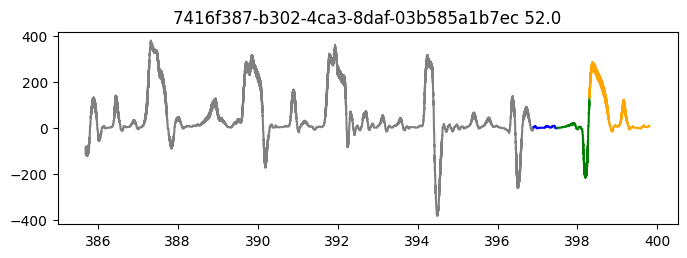

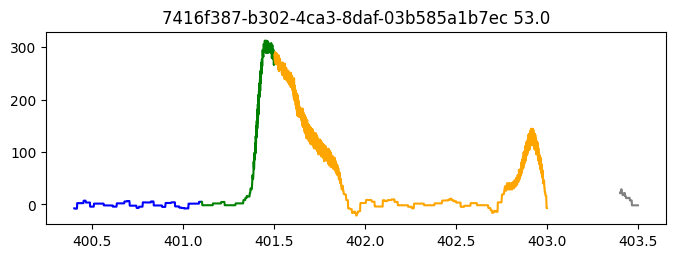

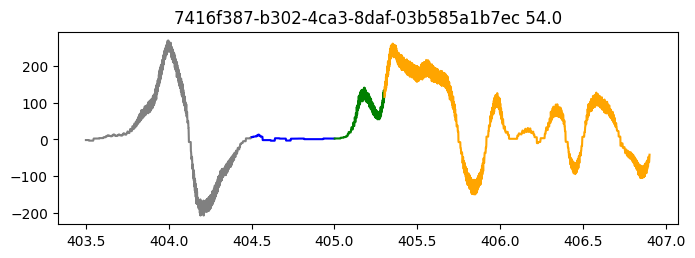

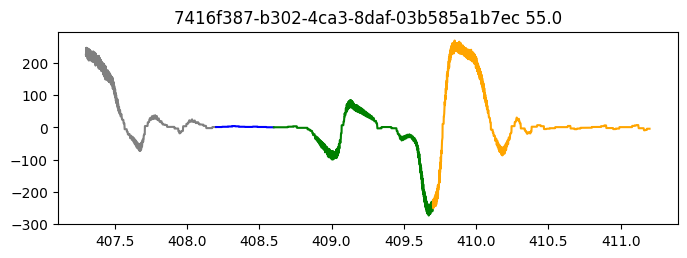

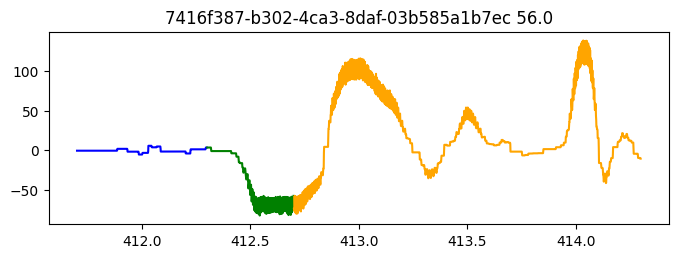

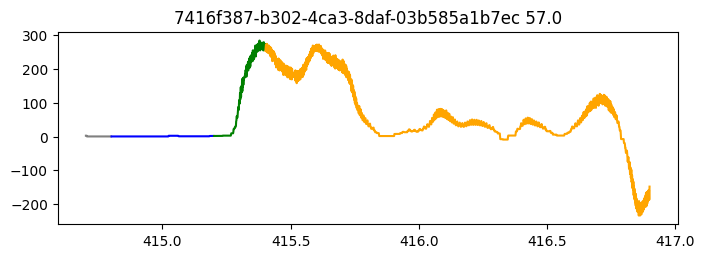

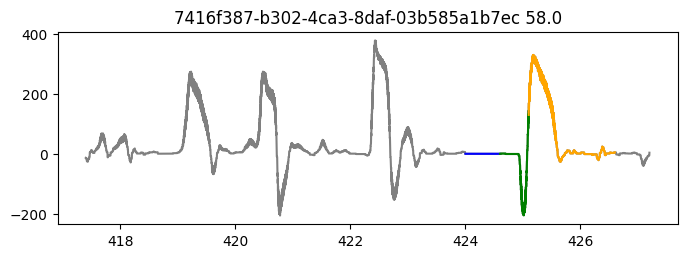

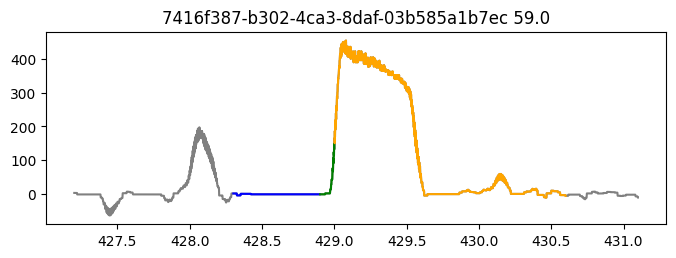

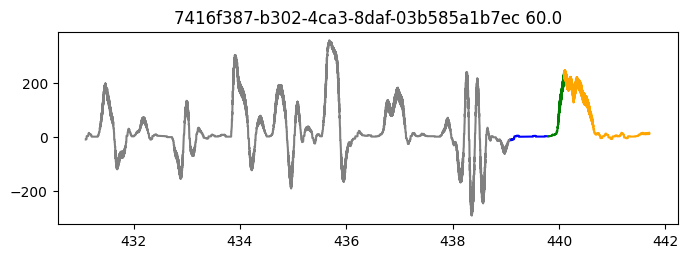

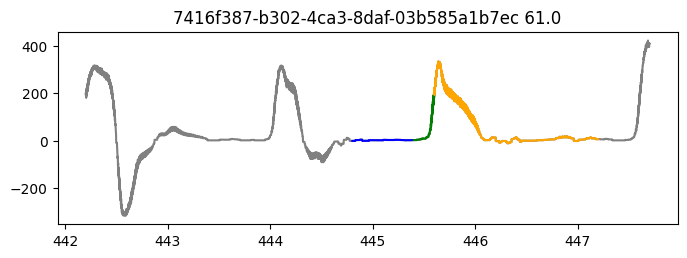

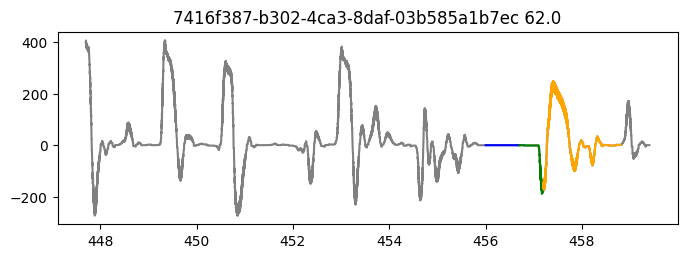

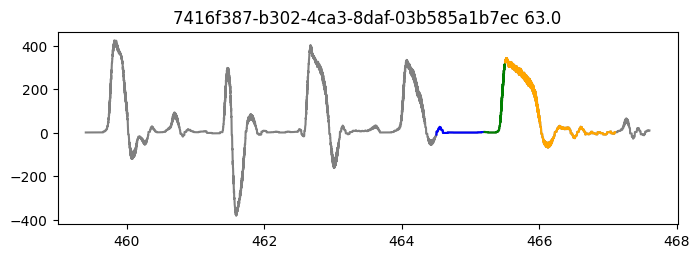

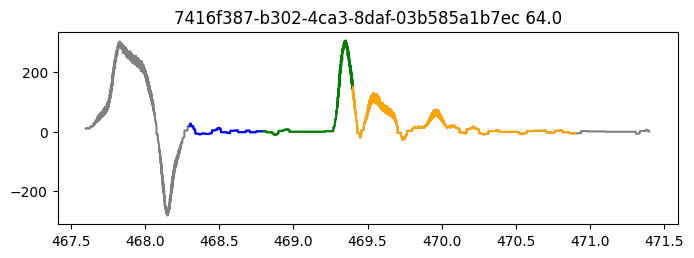

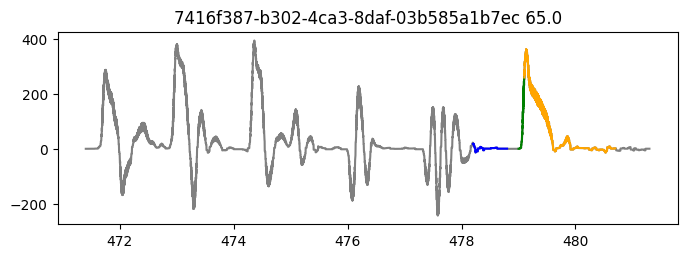

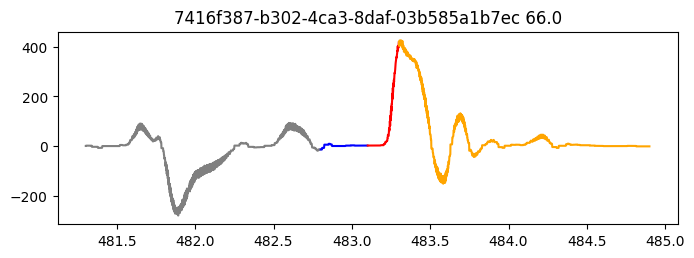

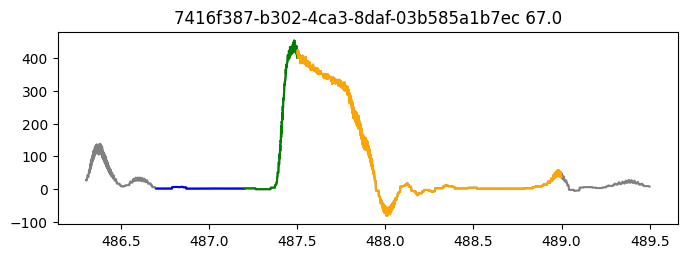

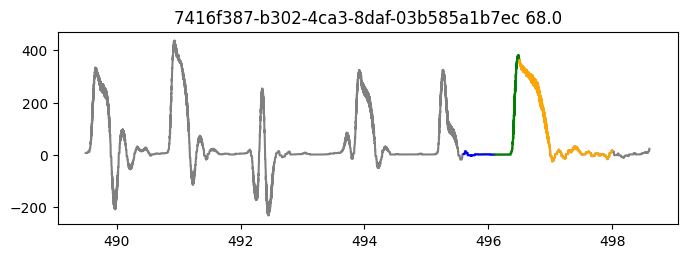

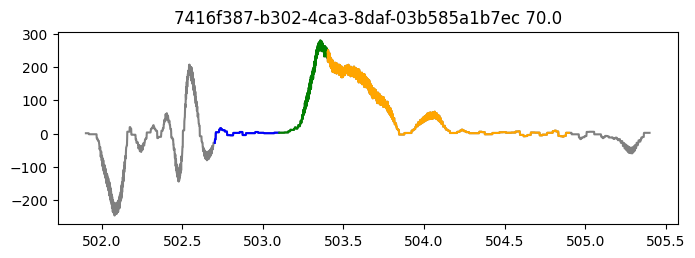

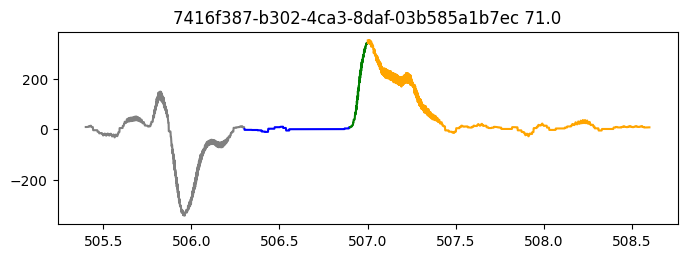

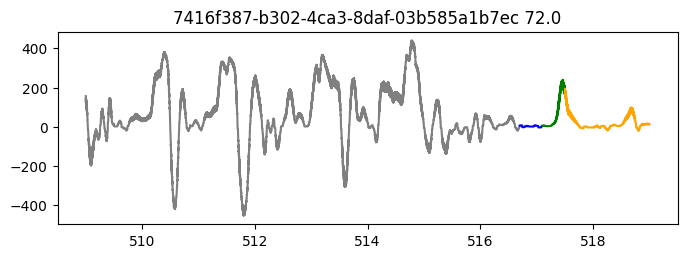

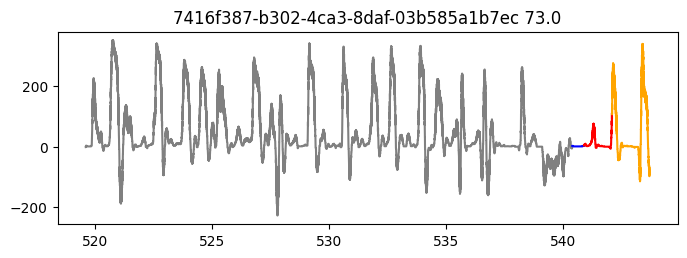

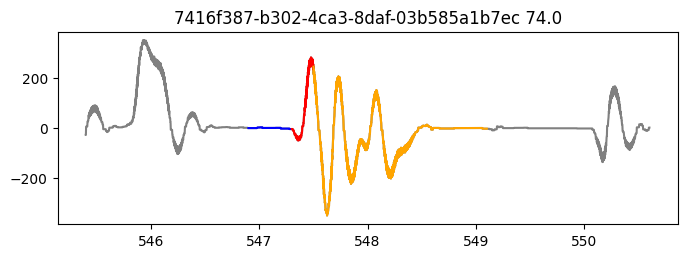

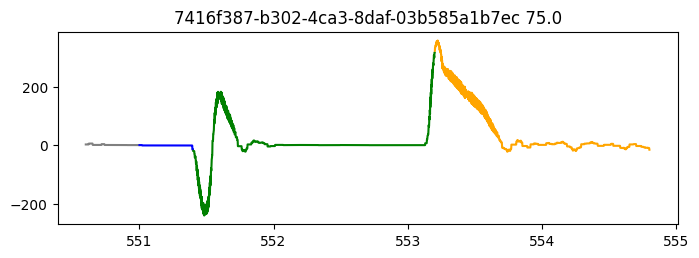

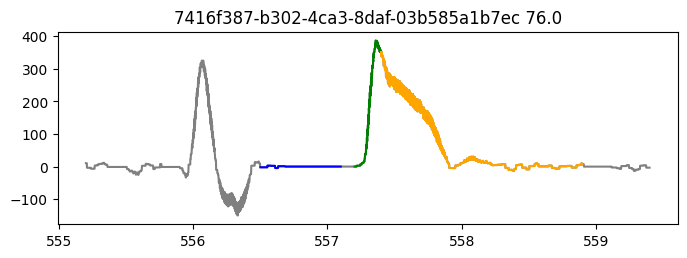

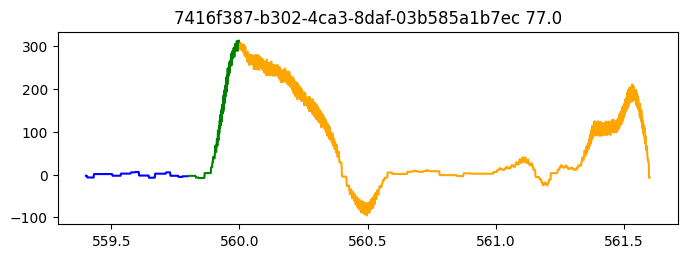

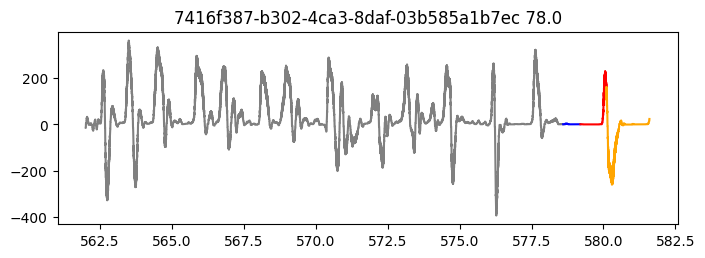

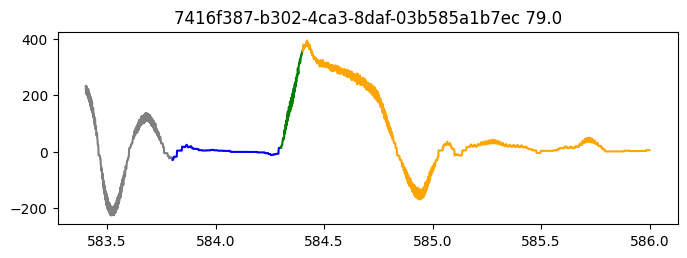

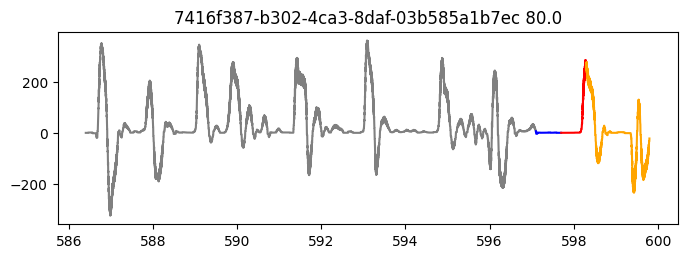

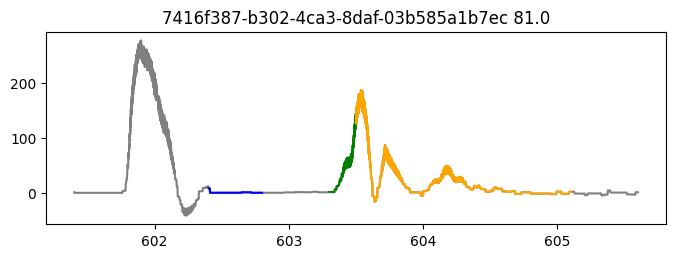

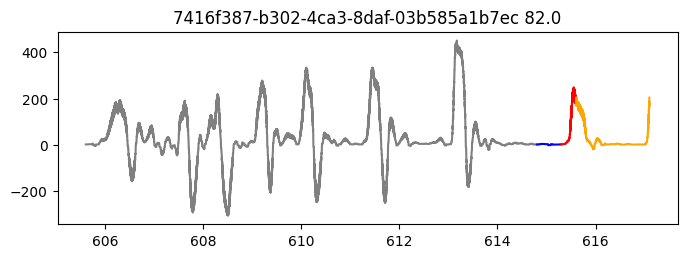

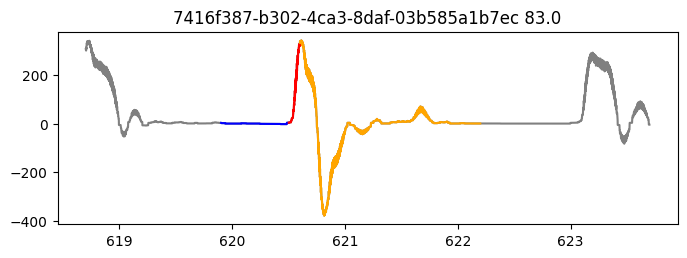

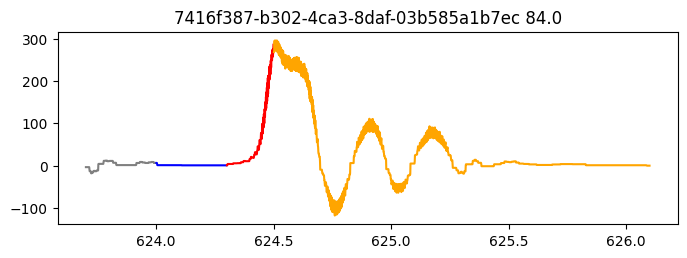

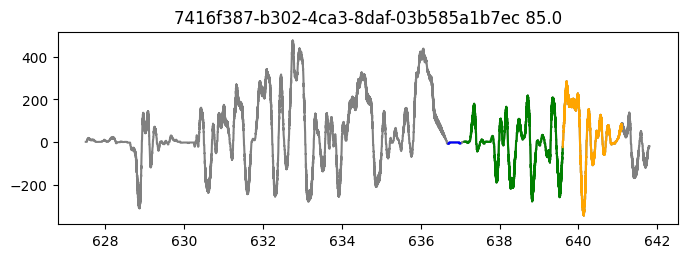

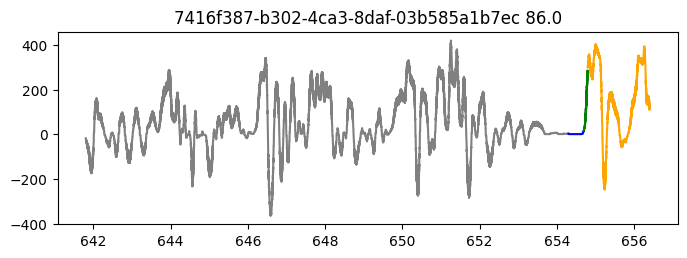

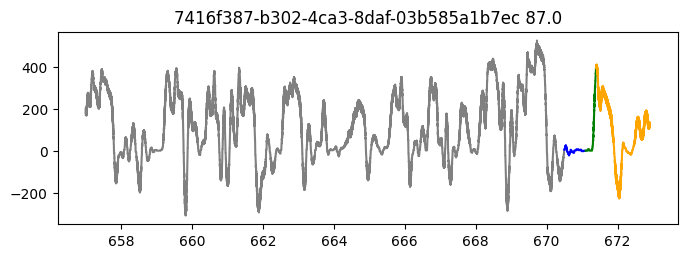

In [30]:
sample = '0f25376f-2b78-4ddc-8c39-b6cdbe7bf5b9 26.0'
eid = sample[:36]

sessions = states_trial_type['session']
states_trial_type['trial_str'] = states_trial_type['trial_id'].astype(str)
states_trial_type['sample'] = states_trial_type[['session', 'trial_str']].agg(' '.join, axis=1)

sessions = states_trial_type['session']
for e, eid in enumerate(sessions[:1]):

    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)

    session_df = states_trial_type.loc[states_trial_type['session']==eid]
    
    samples = session_df['sample'].unique()
    
    for s, sample in enumerate(samples):
        states_trial_type['trial_str'] = states_trial_type['trial_id'].astype(str)
        states_trial_type['sample'] = states_trial_type[['session', 'trial_str']].agg(' '.join, axis=1)
        trial = states_trial_type.loc[states_trial_type['sample']==sample]
        pre_qui = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label']=='Pre-quiescence')]
        qui = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label']=='Quiescence')]
        stimulus = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label']=='Stimulus')]
        choice = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label']=='Choice')]
        iti = states_trial_type.loc[(states_trial_type['sample']==sample)
                                        & (states_trial_type['broader_label']=='ITI')]

        pre_qui_init = np.min(pre_qui['Bin']) * 0.1
        pre_qui_end = (np.max(pre_qui['Bin'])+1)* 0.1
        qui_init = np.min(qui['Bin'])* 0.1
        qui_end = (np.max(qui['Bin'])+1)* 0.1
        stim_init = np.min(stimulus['Bin'])* 0.1
        stim_end = (np.max(stimulus['Bin'])+1)* 0.1
        choice_init = np.min(choice['Bin'])* 0.1
        choice_end = (np.max(choice['Bin'])+1)* 0.1
        iti_init = np.min(iti['Bin'])* 0.1
        iti_end = (np.max(iti['Bin'])+1)* 0.1

        movement_pos_deg = pos * 180 / np.pi # convert from radians to degrees
                
                
        fig, ax = plt.subplots(figsize=(8, 2.5))
        # Plot pre-quiescence
        movement_snippet = movement_pos_deg[np.where((wheel_times> pre_qui_init) & (wheel_times< pre_qui_end))]
        time_snippet = wheel_times[np.where((wheel_times> pre_qui_init) & (wheel_times< pre_qui_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        plt.plot(time_snippet[1:], movement_velocity, color='grey')

        # Plot quiescence
        movement_snippet = movement_pos_deg[np.where((wheel_times> qui_init) & (wheel_times< qui_end))]
        time_snippet = wheel_times[np.where((wheel_times> qui_init) & (wheel_times< qui_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        plt.plot(time_snippet[1:], movement_velocity, color='blue')

        # Plot stimulus
        movement_snippet = movement_pos_deg[np.where((wheel_times> stim_init) & (wheel_times< stim_end))]
        time_snippet = wheel_times[np.where((wheel_times> stim_init) & (wheel_times< stim_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        plt.plot(time_snippet[1:], movement_velocity, color='green')

        # Plot choice
        movement_snippet = movement_pos_deg[np.where((wheel_times> choice_init) & (wheel_times< choice_end))]
        time_snippet = wheel_times[np.where((wheel_times> choice_init) & (wheel_times< choice_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        if list(trial['correct'])[0]==1.0:
            color='green'
        else:
            color='red'
        # plt.plot((time_snippet[1:]-pre_qui_init)*10, movement_velocity/40, color=color)
        plt.plot(time_snippet[1:], movement_velocity, color=color)

        # Plot iti
        movement_snippet = movement_pos_deg[np.where((wheel_times> iti_init) & (wheel_times< iti_end))]
        time_snippet = wheel_times[np.where((wheel_times> iti_init) & (wheel_times< iti_end))]
        movement_velocity = np.diff(movement_snippet) /  np.diff(time_snippet)
        plt.plot(time_snippet[1:], movement_velocity, color='orange')
        plt.title(sample)
        plt.show()

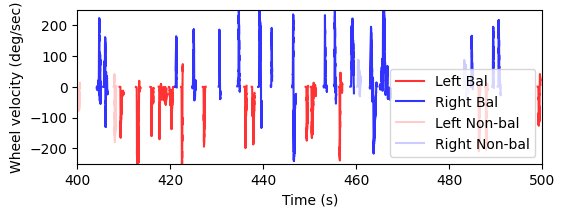

In [54]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions[:1]):
    eid = '934dd7a4-fbdc-459c-8830-04fe9033bc28'
    eid = '03063955-2523-47bd-ae57-f7489dd40f15'
    
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]

    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]
    fig, ax = plt.subplots(figsize=(6, 2))
    plt.plot(balistic_left['time'], balistic_left['wheel_vel'], color='red', alpha=0.8, label='Left Bal')
    plt.plot(balistic_right['time'], balistic_right['wheel_vel'], color='blue', alpha=0.8, label='Right Bal')
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_vel'], color='red', alpha=0.2, label='Left Non-bal')
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_vel'], color='blue', alpha=0.2, label='Right Non-bal')
    plt.plot(no_response['time'], no_response['wheel_vel'], color='grey', alpha=0.5)
    plt.xlim([400, 500])
    plt.ylim([-250,250])
    # plt.xticks([250, 260, 270], [250, 260, 270])
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel velocity (deg/sec)')
    plt.show()

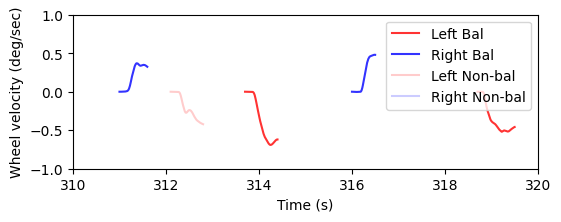

In [35]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions[:1]):
    eid = '934dd7a4-fbdc-459c-8830-04fe9033bc28'
    eid = '03063955-2523-47bd-ae57-f7489dd40f15'
    
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]

    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]
    fig, ax = plt.subplots(figsize=(6, 2))
    plt.plot(balistic_left['time'], balistic_left['wheel_pos'], color='red', alpha=0.8, label='Left Bal')
    plt.plot(balistic_right['time'], balistic_right['wheel_pos'], color='blue', alpha=0.8, label='Right Bal')
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_pos'], color='red', alpha=0.2, label='Left Non-bal')
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_pos'], color='blue', alpha=0.2, label='Right Non-bal')
    plt.plot(no_response['time'], no_response['wheel_pos'], color='grey', alpha=0.5)
    plt.xlim([310, 320])
    plt.ylim([-1,1])
    # plt.xticks([250, 260, 270], [250, 260, 270])
    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel velocity (deg/sec)')
    plt.show()

# Get extended states without wheel data

In [8]:

eids = np.unique(states_trial_type['session'])

mouse_movements_df = pd.DataFrame()

for e, eid in enumerate(eids[0:1]):
    eid = '934dd7a4-fbdc-459c-8830-04fe9033bc28'
    # Get trials
    session_trials = one.load_object(eid, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    unbiased = session_trials.loc[session_trials['probabilityLeft']==0.5]
    time_trial_90 = list(unbiased['stimOff_times'])[-1]

    # Get whel data
    wheel_data = one.load_object(eid, 'wheel', collection='alf')
    pos, wheel_times = wh.interpolate_position(wheel_data.timestamps, wheel_data.position)
    wheel_vel = wheel_velocity(bin_size, wheel_times, pos, unbiased)
    wheel_trace = np.array(wheel_vel['avg_wheel_vel'])

    # Find movements
    df = states_trial_type[['Bin', 'trial_id', 'mouse_name', 'session', 'identifiable_states']].copy()
    df = df.loc[(df['session']==eid)].sort_values(by='Bin')
    check_states = np.array(df['identifiable_states'])
    on = [s[0] == '1' for s in check_states]
    df['wheel_on'] = np.zeros(len(df))
    df['wheel_on'][on] = 1
    df['dif'] = np.zeros(len(df)) * np.nan
    df['dif'][1:] = np.diff(df['wheel_on'])
    movement_onsets = np.array(df.loc[df['dif']==1., 'Bin'])
    movement_offsets = np.array(df.loc[df['dif']==-1., 'Bin'])

    # Initialize new columns
    df['virtual_response'] = df['dif'] * np.nan
    df['ballistic'] = df['dif'] * np.nan

    # Calculate per movement
    for m, onset in enumerate(movement_onsets[:-1]):
        
        if movement_offsets[m] < onset:
            offset = movement_offsets[m+1]
        else:
            offset = movement_offsets[m]
        movement_pos = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                    & (wheel_vel['Bin']<offset), 'Wheel position']
        movement_times = wheel_vel.loc[(wheel_vel['Bin']>=onset)
                                    & (wheel_vel['Bin']<offset), 'Wheel times']
        
        time_interval = (offset - onset) * .1 # convert from Bins to seconds
        movement_pos_deg = movement_pos * 180 / np.pi # convert from radians to degrees
        movement_velocity = np.diff(movement_pos_deg) /  np.diff(movement_times)
        norm_movement_pos = np.array(movement_pos) - np.array(movement_pos)[0]

        # Find positions above threshold
        pos_above_thr = np.where(np.abs(norm_movement_pos)>response_threshold)
        if len(pos_above_thr[0]) > 0:
            response_index = np.where(np.abs(norm_movement_pos)>response_threshold)[0][0]
            response = np.sign(norm_movement_pos[response_index])

            # Find ballistic movements
            # Velocity above threshold
            vel_above_thr = np.where(np.abs(movement_velocity)>=velocity_threshold)
            # Response duration
            response_duration = np.array(movement_times)[response_index] - np.array(movement_times)[0]
            # Monotonic change?
            response_movement = norm_movement_pos[:response_index]
            
            # If response is very short and crosses response threshold, assume it's ballistic
            if len(response_movement)<100:
                ballistic = True
            else:
                # Otherwise check monotonicity 
                smoothed_movement = savgol_filter(response_movement, 100, 2)
                significant_inflection = np.where(np.diff(np.abs(smoothed_movement))<monotonic_threshold)

                if len(vel_above_thr[0]) > 0:
                    # Check if threshold achieved before 1 s and 
                    # velocity threshold achieved before response threshold and
                    # monotonically changing before response threshold
                    if (np.sum(vel_above_thr[0] < response_index) > 0) & (response_duration < 1) & (len(significant_inflection[0]) == 0):
                        ballistic = True
                    else:
                        ballistic = False
                else:
                    ballistic = False
        else:
            response = np.nan
            ballistic = False

        # Save data
        df.loc[(df['Bin']>=onset) & (df['Bin']<offset), 'virtual_response'] = response
        df.loc[(df['Bin']>=onset) & (df['Bin']<offset), 'ballistic'] = ballistic
    
    # Save to big df
    if len(mouse_movements_df) == 0:
        mouse_movements_df = df.copy()
    else:
        mouse_movements_df = mouse_movements_df.append(df)


/tmp/ipykernel_19789/2527699246.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wheel_on'][on] = 1
/tmp/ipykernel_19789/2527699246.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dif'][1:] = np.diff(df['wheel_on'])


In [80]:
mouse_movements_df.to_pickle("mouse_movements_df.pkl")  

Text(0.5, 0, 'Time (s)')

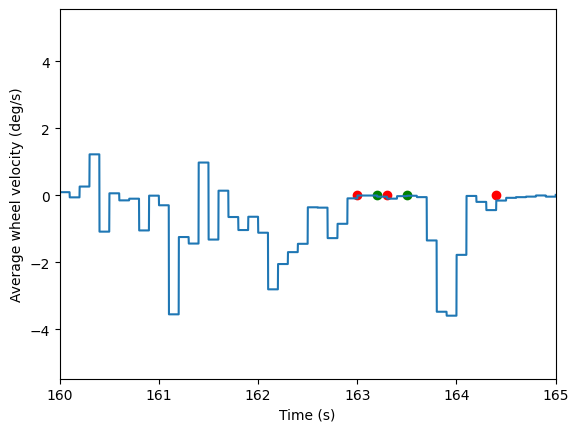

In [73]:
plt.scatter(movement_onsets/10, np.ones(len(movement_onsets))-1, color='green')
plt.scatter(movement_offsets/10, np.ones(len(movement_offsets))-1, color='red')
# plt.plot(wheel_times*10, pos)
plt.plot(wheel_times, wheel_trace)
# plt.scatter(df['Bin'], df['wheel_on'], alpha=0.5)
# plt.scatter(df['Bin'], df['dif'], color='black', alpha=0.5)
plt.xlim([160, 165])
# plt.ylim([-4, 4])
plt.ylabel('Average wheel velocity (deg/s)')
plt.xlabel('Time (s)')

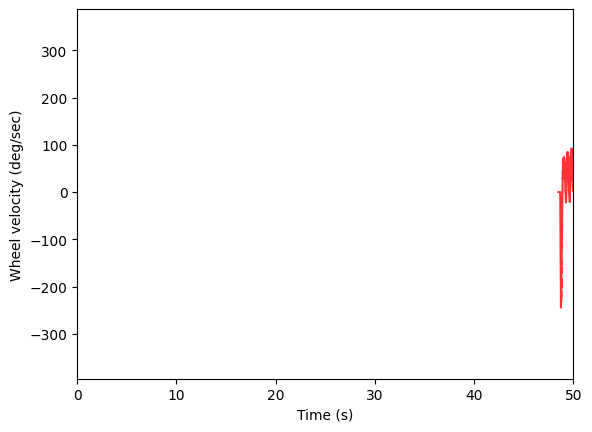

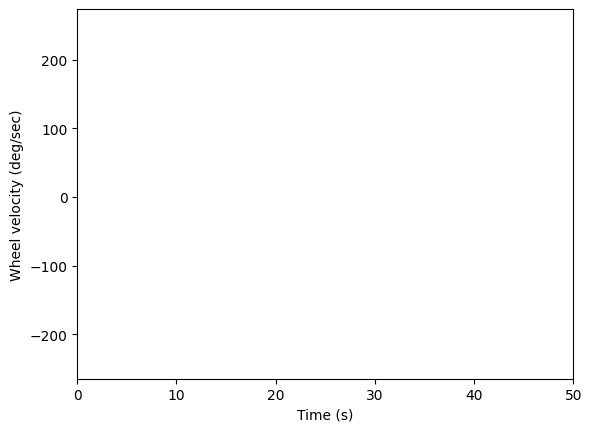

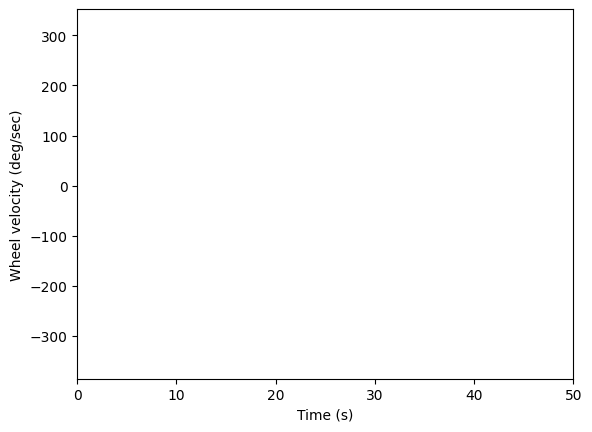

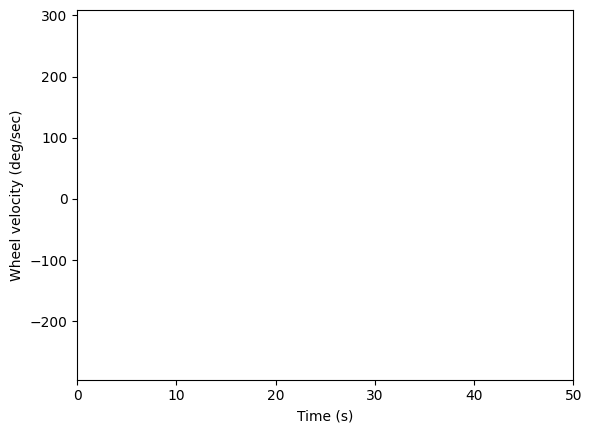

In [15]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]

    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]

    plt.plot(balistic_left['time'], balistic_left['wheel_vel'], color='red', alpha=0.8)
    plt.plot(balistic_right['time'], balistic_right['wheel_vel'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_vel'], color='red', alpha=0.2)
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_vel'], color='blue', alpha=0.2)
    plt.plot(no_response['time'], no_response['wheel_vel'], color='grey', alpha=0.5)
    plt.xlim([00, 50])
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel velocity (deg/sec)')
    plt.show()

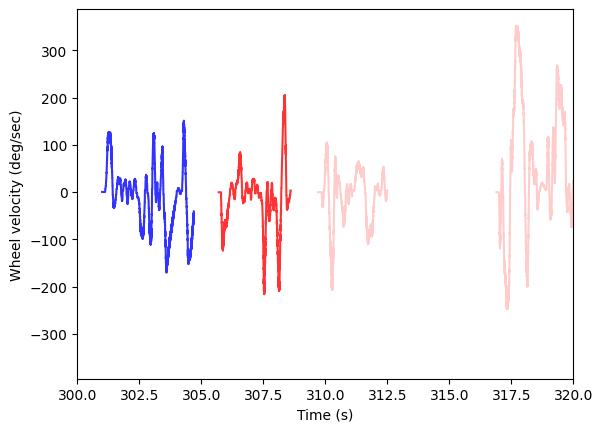

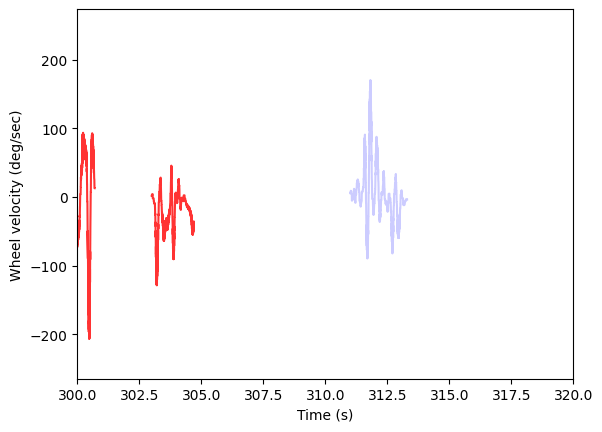

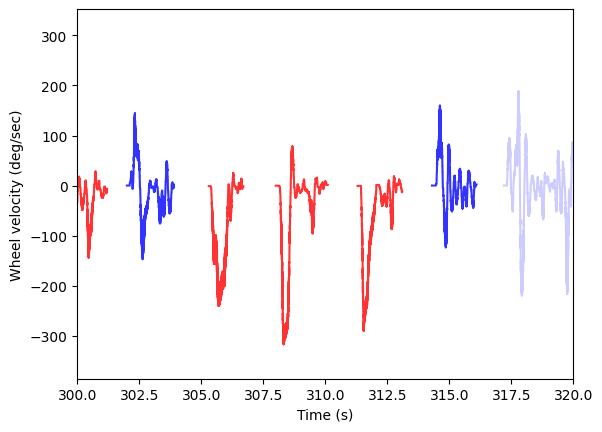

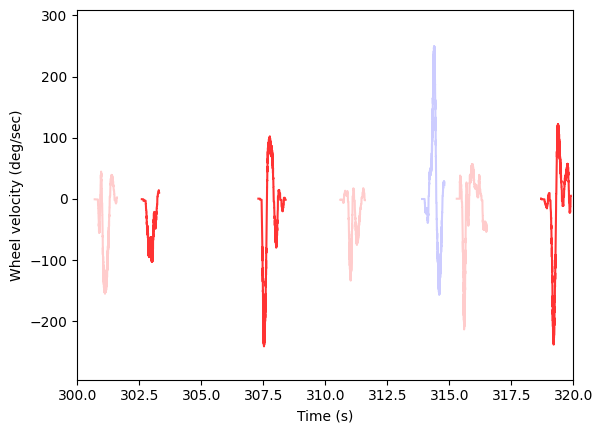

In [43]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]

    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]

    plt.plot(balistic_left['time'], balistic_left['wheel_vel'], color='red', alpha=0.8)
    plt.plot(balistic_right['time'], balistic_right['wheel_vel'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_vel'], color='red', alpha=0.2)
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_vel'], color='blue', alpha=0.2)
    plt.plot(no_response['time'], no_response['wheel_vel'], color='grey', alpha=0.5)
    plt.xlim([300, 320])
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel velocity (deg/sec)')
    plt.show()

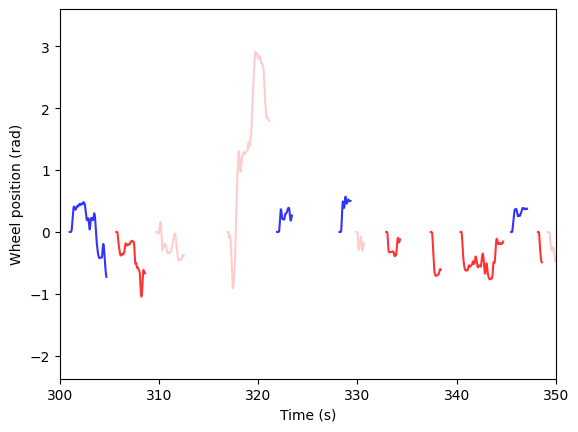

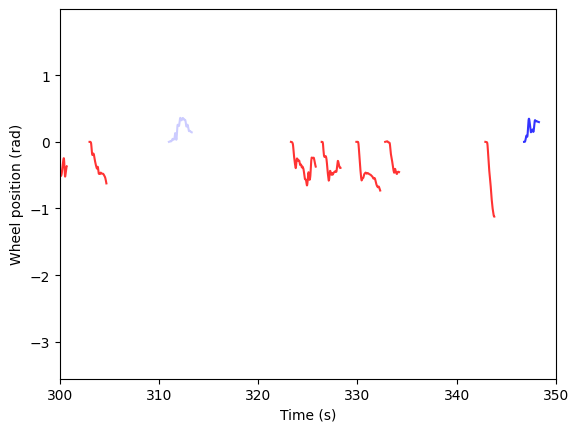

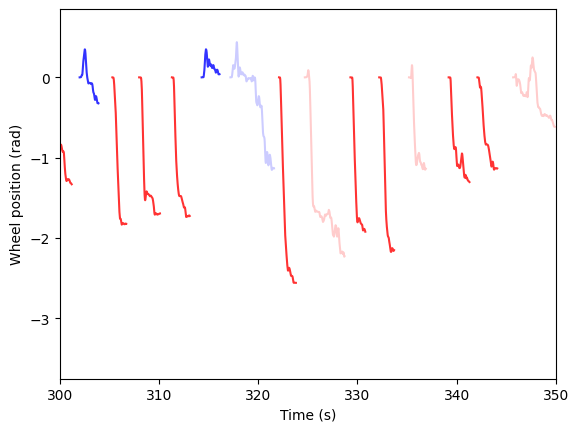

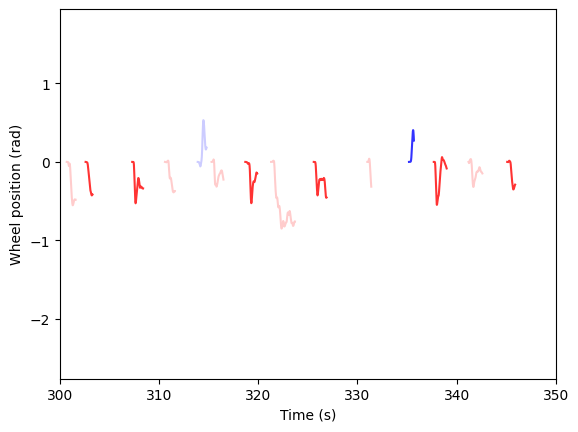

In [42]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]
    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]

    plt.plot(balistic_left['time'], balistic_left['wheel_pos'], color='red', alpha=0.8)
    plt.plot(balistic_right['time'], balistic_right['wheel_pos'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_pos'], color='red', alpha=0.2)
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_pos'], color='blue', alpha=0.2)
    plt.plot(no_response['time'], no_response['wheel_pos'], color='grey', alpha=0.5)
    plt.xlim([300, 350])
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel position (rad)')
    plt.show()

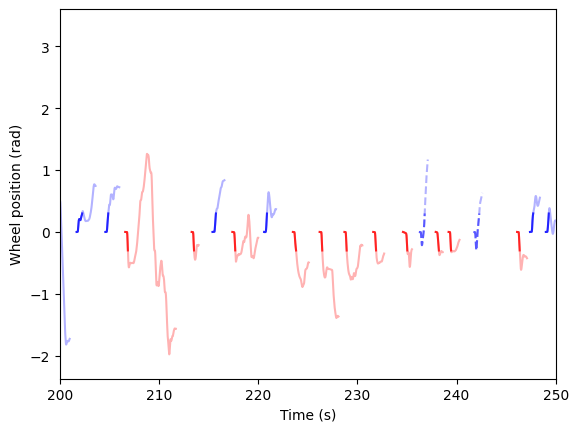

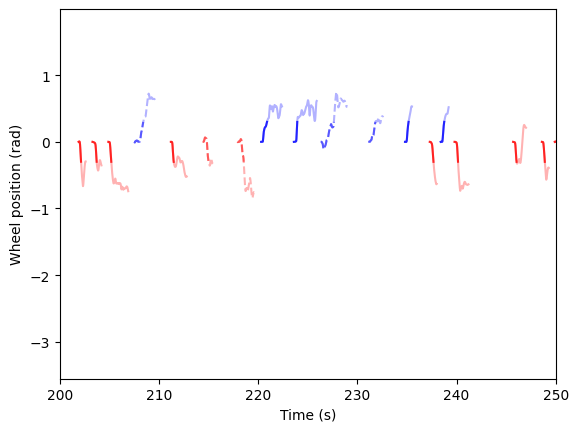

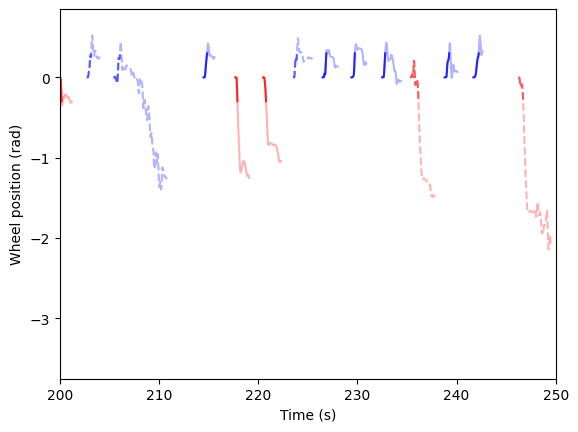

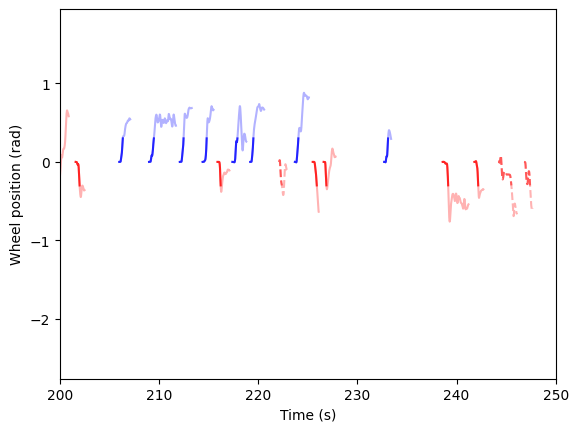

In [41]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]
    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]

    plt.plot(balistic_left['time'], balistic_left['wheel_pos_resp'], color='red', alpha=0.8)
    plt.plot(balistic_right['time'], balistic_right['wheel_pos_resp'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_pos_resp'], color='red', alpha=0.5, linestyle='--')
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_pos_resp'], color='blue', alpha=0.5, linestyle='--')

    plt.plot(balistic_left['time'], balistic_left['wheel_pos'], color='red', alpha=0.3)
    plt.plot(balistic_right['time'], balistic_right['wheel_pos'], color='blue', alpha=0.3)
    plt.plot(non_balistic_l['time'], non_balistic_l['wheel_pos'], color='red', alpha=0.3, linestyle='--')
    plt.plot(non_balistic_r['time'], non_balistic_r['wheel_pos'], color='blue', alpha=0.3, linestyle='--')
    plt.plot(no_response['time'], no_response['wheel_pos'], color='grey', alpha=0.6)
    plt.xlim([200, 250])
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel position (rad)')
    plt.show()

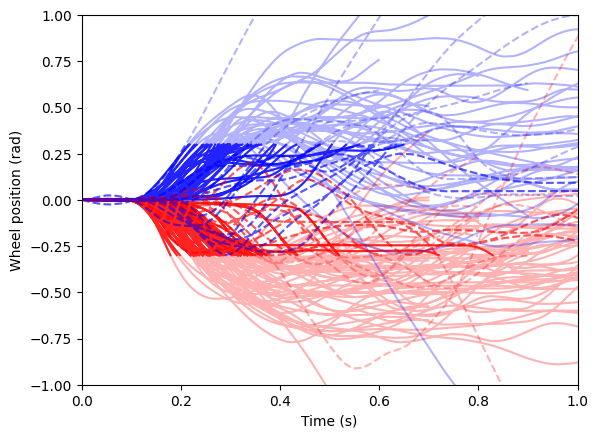

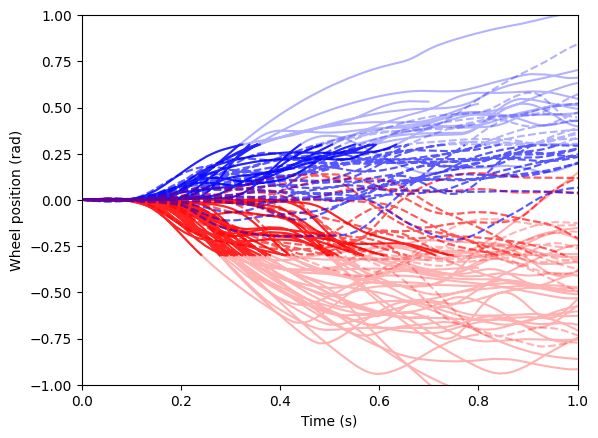

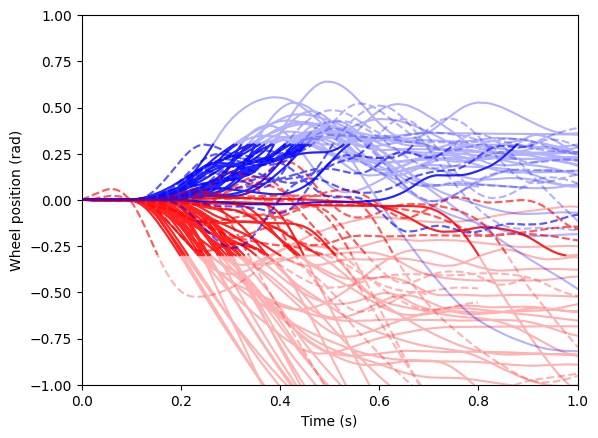

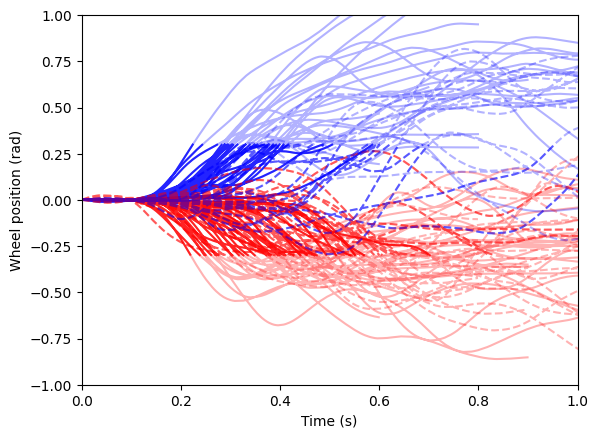

In [40]:
sessions = mouse_movements_df['session'].unique()
for e, eid in enumerate(sessions):
    use_data = mouse_movements_df.loc[mouse_movements_df['session']==eid]
    # Plot
    balistic_left = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==-1.)]
    balistic_right = use_data.loc[(use_data['ballistic']==True)
                                        & (use_data['response']==1.)]
    non_balistic_l = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==-1.)]
    non_balistic_r = use_data.loc[(use_data['ballistic']==False)
                                        & (use_data['response']==1.)]
    no_response = use_data.loc[use_data['response']==np.nan]
    
    plt.plot(balistic_left['norm_time'], balistic_left['wheel_pos_resp'], color='red', alpha=0.8)
    plt.plot(balistic_right['norm_time'], balistic_right['wheel_pos_resp'], color='blue', alpha=0.8)
    plt.plot(non_balistic_l['norm_time'], non_balistic_l['wheel_pos_resp'], color='red', alpha=0.5, linestyle='--')
    plt.plot(non_balistic_r['norm_time'], non_balistic_r['wheel_pos_resp'], color='blue', alpha=0.5, linestyle='--')

    plt.plot(balistic_left['norm_time'], balistic_left['wheel_pos'], color='red', alpha=0.3)
    plt.plot(balistic_right['norm_time'], balistic_right['wheel_pos'], color='blue', alpha=0.3)
    plt.plot(non_balistic_l['norm_time'], non_balistic_l['wheel_pos'], color='red', alpha=0.3, linestyle='--')
    plt.plot(non_balistic_r['norm_time'], non_balistic_r['wheel_pos'], color='blue', alpha=0.3, linestyle='--')
    plt.plot(no_response['norm_time'], no_response['wheel_pos'], color='grey', alpha=0.6)
    plt.xlim([0,1])
    plt.ylim([-1, 1])
    plt.xlabel('Time (s)')
    plt.ylabel('Wheel position (rad)')
    plt.show()